In [281]:
import pandas as pd
import numpy as np
from datetime import datetime
import os,sys
import sqlite3
import csv
from IPython.display import display
from sqlalchemy import create_engine # database connection
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from __future__ import division
from sklearn.metrics import precision_recall_curve
%matplotlib inline

In [ ]:
mo = pd.merge(moo, weather, how= 'inner', on='geoID')

mo.to_pickle('finallistofalldata.p')

In [ ]:
#import all the previously processed data
mo = pd.read_pickle('finallistofalldata.p')

weather = pd.read_pickle('weather311_summary.p')

In [272]:
X = mo.drop(['geoID', 'WCount', 'Wratio', 'ColdTotal', 'NormalTotal', 'NormalDaily', 'TotalDaily', 'Ratio'], axis = 1)

In [256]:
#create a random variable 
ran

array([ 0.66555224,  0.95905912,  1.40214593, ...,  0.06258427,
       -0.89211333, -0.78823248])

In [273]:
#add to features to gauge feature importance
X['ran1'] = ran

In [249]:
#predicting whether a census tract contains a watch-list building or not
# making sure the classes are not too unbalanced
y = mo['Wratio']
#y[y<0.5] = 0
y[y>0] = 1
#y = y.astype(int)
y.sum()/len(y)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


0.6118721461187214

In [250]:
from sklearn.cross_validation import StratifiedShuffleSplit, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [290]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.4)

In [291]:
yguess = []
models = {
    'LogisticReg': LogisticRegression(),
   # 'KNN': KNeighborsClassifier(n_neighbors=4),
    #'SVC': SVC(probability=True),
    #'RandomForest': RandomForestClassifier(),
    #'GradientBoost': GradientBoostingClassifier(learning_rate= 0.3),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, learning_rate= 0.3)
    
}

for name, model in models.iteritems():
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    
    print name
    print 'accuracy:', accuracy_score(ytest, ypred)
    print 'precision:', precision_score(ytest, ypred)
    print 'recall:', recall_score(ytest, ypred)
    print 'f1:', f1_score(ytest, ypred)
    print '\n'
    if name in ['AdaBoost', 'LogisticReg']:
        yguess.append(ypred)
    
y_avg = np.mean(yguess, axis = 0)
y_avg = y_avg.astype(int)
print 'Ada + Log'
print 'accuracy:', accuracy_score(ytest, y_avg)
print 'precision:', precision_score(ytest, y_avg)
print 'recall:', recall_score(ytest, y_avg)
print 'f1:', f1_score(ytest, y_avg)
print '\n'

LogisticReg
accuracy: 0.788339670469
precision: 0.782196969697
recall: 0.888172043011
f1: 0.831822759315


AdaBoost
accuracy: 0.785804816223
precision: 0.786821705426
recall: 0.87311827957
f1: 0.827726809378


Ada + Log
accuracy: 0.801013941698
precision: 0.816872427984
recall: 0.85376344086
f1: 0.8349106204




LogisticReg auc: 0.858044603744
AdaBoost auc: 0.857364263905


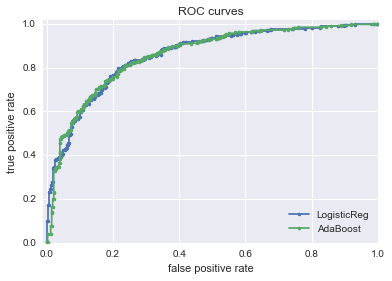

In [311]:

yproba = []
for name, model in models.iteritems():
    
    model.fit(Xtrain, ytrain)
    if name in ['AdaBoost', 'LogisticReg']:
        yproba.append(model.predict_proba(Xtest)[:, 1])
    
    fpr, tpr, threshold = roc_curve(ytest, model.predict_proba(Xtest)[:, 1])
    plt.plot(fpr, tpr,  linestyle = '-', marker = '.', label = name)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.02])
    print name+' auc:', auc(fpr, tpr)

#y_avg = np.mean(yproba, axis = 0)
#fpr, tpr, threshold = roc_curve(ytest, y_avg)
#plt.plot(fpr, tpr,  linestyle = '--',  label = 'Avg Model')
#print 'avg auc:', auc(fpr, tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curves')
plt.legend(loc = 'lower right')

LogisticReg auc: 0.857364263905
AdaBoost auc: 0.857364263905


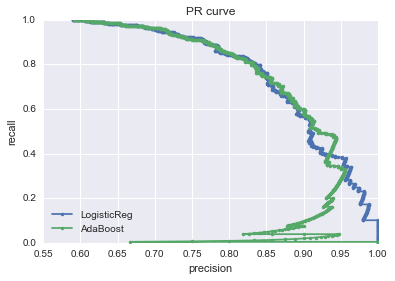

In [313]:
for name, model in models.iteritems():
    
    model.fit(Xtrain, ytrain)
    precision, recall, thresholds = precision_recall_curve(ytest, model.predict_proba(Xtest)[:, 1])
   
    plt.plot(precision, recall,  linestyle = '-', marker = '.', label = name)
   # plt.xlim([-0.01, 1])
   # plt.ylim([0, 1.02])
    print name+' auc:', auc(fpr, tpr)

#y_avg = np.mean(yproba, axis = 0)
#precision, recall, threshold = precision_recall_curve(ytest, y_avg)
#plt.plot(precision, recall,  linestyle = '-', marker = '.', label = 'Avg model')
#print 'avg auc:', auc(fpr, tpr)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('PR curve')
plt.legend(loc = 'lower left')

In [314]:
ada = AdaBoostClassifier( n_estimators=100, learning_rate= 0.3)
ada.fit(Xtrain, ytrain)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.3, n_estimators=100, random_state=None)

In [316]:
print ada.score(Xtest, ytest)
sorted_features = sorted(zip(X.columns,ada.feature_importances_), key=lambda tup: abs(tup[1]), reverse=True)
sorted_features

0.785804816223


[('TotalB', 0.11),
 ('Total', 0.10000000000000001),
 ('RC', 0.089999999999999997),
 ('OwnerRenter', 0.089999999999999997),
 ('YearBuilt', 0.080000000000000002),
 ('Long', 0.070000000000000007),
 ('NonFamFam', 0.070000000000000007),
 ('income per capita', 0.059999999999999998),
 ('total housing units', 0.059999999999999998),
 ('Lat', 0.050000000000000003),
 ('Median Age', 0.040000000000000001),
 ('AvgHouse', 0.040000000000000001),
 ('AvgFam', 0.040000000000000001),
 ('ColdDaily', 0.040000000000000001),
 ('ran1', 0.029999999999999999),
 ('PercentPopChange', 0.02),
 ('median rent', 0.01),
 ('Total Population', 0.0)]

In [77]:
import statsmodels.api as sm

In [317]:
logit = sm.Logit(y,X.astype(float))
results = logit.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.430467
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Wratio   No. Observations:                 1971
Model:                          Logit   Df Residuals:                     1953
Method:                           MLE   Df Model:                           17
Date:                Thu, 27 Oct 2016   Pseudo R-squ.:                  0.3555
Time:                        21:23:15   Log-Likelihood:                -848.45
converged:                       True   LL-Null:                       -1316.4
                                        LLR p-value:                4.392e-188
=======================================================================================
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
YearBuilt              -0.0202      0.004     -4.912      0.000        -0.028    -0.012
Lat                    -0.0842      0.706     -0.119      0.905        -1.469     1.300
Long                   -0.5382      0.387     -1.390      0.165        -1.297     0.221
RC                     -0.9075      0.392     -2.316      0.021        -1.676    -0.139
TotalB                  0.0111      0.002      6.369      0.000         0.008     0.015
Total Population       -0.0002   9.41e-05     -1.687      0.092        -0.000  2.57e-05
income per capita    1.312e-05   4.31e-06      3.042      0.002      4.67e-06  2.16e-05
Median Age             -0.0291      0.012     -2.332      0.020        -0.054    -0.005
total housing units     0.0002      0.000      1.107      0.268        -0.000     0.001
median rent            -0.0004      0.000     -1.450      0.147        -0.001     0.000
OwnerRenter            -0.7548      0.091     -8.256      0.000        -0.934    -0.576
NonFamFam               0.1238      0.080      1.547      0.122        -0.033     0.281
AvgHouse                0.5749      0.412      1.396      0.163        -0.232     1.382
AvgFam                  0.8483      0.535      1.586      0.113        -0.200     1.897
PercentPopChange       -0.0013      0.001     -1.008      0.313        -0.004     0.001
Total                   0.0007      0.000      6.229      0.000         0.000     0.001
ColdDaily              -0.2093      0.171     -1.221      0.222        -0.545     0.127
ran1                   -0.0373      0.059     -0.631      0.528        -0.153     0.079
=======================================================================================
"""

### prepare the data for plotting in CartoDB

In [147]:
geocodes = pd.read_csv('CTpop.csv')

In [158]:
geodict = {
    5: '2',
    47: '3',
    61: '1',
    81: '4',
    85: '5'
    
}

In [165]:
borogeoID = []
for i in range(len(geocodes)):
    m = geocodes.loc[i]
    b = geodict[m.boroCode]
    new = b+str(m['Unnamed: 6'])[-6:]
    borogeoID.append(new)    


In [166]:
len(geocodes)

2167

In [167]:
len(borogeoID)

2167

In [191]:
geocodes2 = pd.concat([pd.DataFrame(borogeoID), geocodes.geoID], axis = 1)

In [213]:
geocodes2['pred'] = ada.predict(X)

In [215]:
geocodes2.columns = ['geoID', 'boro_ct_20', 'predproba', 'Wratio', 'pred']

In [180]:
mos = pd.concat([mo.geoID, mo.Wratio], axis = 1)

In [192]:
geocodes2 = pd.merge(mos, geocodes2, on='geoID')

In [183]:
len(geocodes2)

1971

In [184]:
len(mo)

1971

In [208]:
geocodes2 = geocodes2.drop('Wratio', axis = 1)

In [200]:
Wratio = mo.WCount/mo.TotalB

In [203]:
Wratio[Wratio>1] = 1

In [211]:
geocodes2['Wratio'] = mo.Wratio

In [237]:
for i in range(len(geocodes2)):
    if geocodes2.loc[i]['WCount']>geocodes2.loc[i]['TotalBuildings']:
        geocodes2.set_value(i, 'TotalBuildings', geocodes2.loc[i]['WCount'])
        print 'yes'

In [244]:
geocodes2['ColdDaily']= mo['ColdDaily']

In [245]:
geocodes2.head()

,geoID,boro_ct_20,predproba,Wratio,pred,YearBuilt,WCount,TotalBuildings,RentControl,IncomePerCapita,OwnerRenter,Total311,Cold311,ColdDaily
0,36005000200,2000200,0.485353,0.0,0.0,1955,0.0,17,0.0,22971.0,1.389948,413,217.0,2.237113
1,36005000400,2000400,0.493022,1.0,0.0,1952,1.0,22,0.0,29803.0,2.733333,1064,478.0,2.426396
2,36005001600,2001600,0.508191,1.0,1.0,1953,1.0,20,0.0,18544.0,0.245258,2401,1233.0,2.740000
3,36005001900,2001900,0.498160,0.0,0.0,1922,0.0,6,0.0,16168.0,0.081152,49,32.0,2.285714
4,36005002000,2002000,0.500057,1.0,1.0,1963,3.0,4,0.0,14052.0,0.202439,2445,1313.0,2.741127


In [246]:
geocodes2.to_csv('datafordisplay.csv')